
## PROFIL
*   Nama: D. Diffran Nur Cahyo
*   Username: diffran
*   Email: diffrannurcahyo@gmail.com
*   Universitas: Universitas Amikom Yogyakarta







###KLASIFIKASI ROCK-PAPER-SCISSORS MENGGUNAKAN CNN NASNETMOBILE

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!unzip "/content/drive/MyDrive/Dataset/rockpaperscissors.zip" -d "/content/drive/MyDrive/Dataset/rockpaperscissors"

Streaming output truncated to the last 5000 lines.
  inflating: /content/drive/MyDrive/Dataset/rockpaperscissors/rockpaperscissors/scissors/KNNsNhduqSfuqEK5.png  
  inflating: /content/drive/MyDrive/Dataset/rockpaperscissors/__MACOSX/rockpaperscissors/scissors/._KNNsNhduqSfuqEK5.png  
  inflating: /content/drive/MyDrive/Dataset/rockpaperscissors/rockpaperscissors/scissors/xAnfzBYnsnuru9Nf.png  
  inflating: /content/drive/MyDrive/Dataset/rockpaperscissors/__MACOSX/rockpaperscissors/scissors/._xAnfzBYnsnuru9Nf.png  
  inflating: /content/drive/MyDrive/Dataset/rockpaperscissors/rockpaperscissors/scissors/caj9PiWZ2BenuxXF.png  
  inflating: /content/drive/MyDrive/Dataset/rockpaperscissors/__MACOSX/rockpaperscissors/scissors/._caj9PiWZ2BenuxXF.png  
  inflating: /content/drive/MyDrive/Dataset/rockpaperscissors/rockpaperscissors/scissors/5CzwWCDnxKOJz5T0.png  
  inflating: /content/drive/MyDrive/Dataset/rockpaperscissors/__MACOSX/rockpaperscissors/scissors/._5CzwWCDnxKOJz5T0.png  
  inflati

In [ ]:
import os
import pandas as pd

sdir=r'/content/drive/MyDrive/Dataset/rockpaperscissors/rockpaperscissors/rps-cv-images'

filepaths=[]
labels=[]
classlist=os.listdir(sdir)
for klass in classlist:
    classpath=os.path.join(sdir,klass)
    if os.path.isdir(classpath):
        flist=os.listdir(classpath)
        for f in flist:
            fpath=os.path.join(classpath,f)
            filepaths.append(fpath)
            labels.append(klass)
Fseries= pd.Series(filepaths, name='filepaths')
Lseries=pd.Series(labels, name='labels')
df=pd.concat([Fseries, Lseries], axis=1)
print (df.head())
print (df['labels'].value_counts())

                                           filepaths labels
0  /content/drive/MyDrive/Dataset/rockpaperscisso...  paper
1  /content/drive/MyDrive/Dataset/rockpaperscisso...  paper
2  /content/drive/MyDrive/Dataset/rockpaperscisso...  paper
3  /content/drive/MyDrive/Dataset/rockpaperscisso...  paper
4  /content/drive/MyDrive/Dataset/rockpaperscisso...  paper
scissors    750
rock        726
paper       712
Name: labels, dtype: int64


### split dataset

In [ ]:
from sklearn.model_selection import train_test_split

train_split = 0.6
validation_split = 0.4

train_df, remaining_df = train_test_split(df, train_size=train_split, random_state=0)

valid_df, test_df = train_test_split(remaining_df, train_size=validation_split, random_state=0)

print('train_df length:', len(train_df))
print('validation_df length:', len(valid_df))
print('test_df length:', len(test_df))

train_df length: 1312
validation_df length: 350
test_df length: 526


### buat train, test, valid  generators

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

height=224
width=224
channels=3
batch_size=64

img_shape=(height, width, channels)
img_size=(height, width)
length=len(test_df)
test_batch_size=sorted([int(length/n) for n in range(1,length+1) if length % n ==0 and length/n<=80],reverse=True)[0]
test_steps=int(length/test_batch_size)
print ( 'test batch size: ' ,test_batch_size, '  test steps: ', test_steps)

gen=ImageDataGenerator(
    rescale=1./255,
    rotation_range = 30,  # randomly rotate images in the range (degrees, 0 to 180)
    zoom_range = 0.2, # Randomly zoom image
    fill_mode = 'nearest',
    width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
    horizontal_flip = True,  # randomly flip images
    #vertical_flip=True  # randomly flip images,
    )
train_gen=gen.flow_from_dataframe( train_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                    color_mode='rgb', shuffle=True, batch_size=batch_size)

validgen=ImageDataGenerator(rescale=1./255,)
valid_gen=validgen.flow_from_dataframe( valid_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                    color_mode='rgb', shuffle=True, batch_size=batch_size)

testgen=ImageDataGenerator(rescale=1./255,)
test_gen=testgen.flow_from_dataframe( test_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                    color_mode='rgb', shuffle=False, batch_size=test_batch_size)

classes=list(train_gen.class_indices.keys())
print (classes)
class_count=len(classes)

test batch size:  2   test steps:  263
Found 1312 validated image filenames belonging to 3 classes.
Found 350 validated image filenames belonging to 3 classes.
Found 526 validated image filenames belonging to 3 classes.
['paper', 'rock', 'scissors']


### menampilkan hasil preproceesing dan augmentasi

In [ ]:
def show_image_samples(gen):
    test_dict=test_gen.class_indices
    classes=list(test_dict.keys())
    images,labels=next(gen) # get a sample batch from the generator
    plt.figure(figsize=(20, 20))
    length=len(labels)
    if length<25:   #show maximum of 25 images
        r=length
    else:
        r=25
    for i in range(r):
        plt.subplot(5, 5, i + 1)
        image=images[i]
        plt.imshow(image)
        index=np.argmax(labels[i])
        class_name=classes[index]
        plt.title(class_name, color='black', fontsize=20)
        plt.axis('off')
    plt.show()

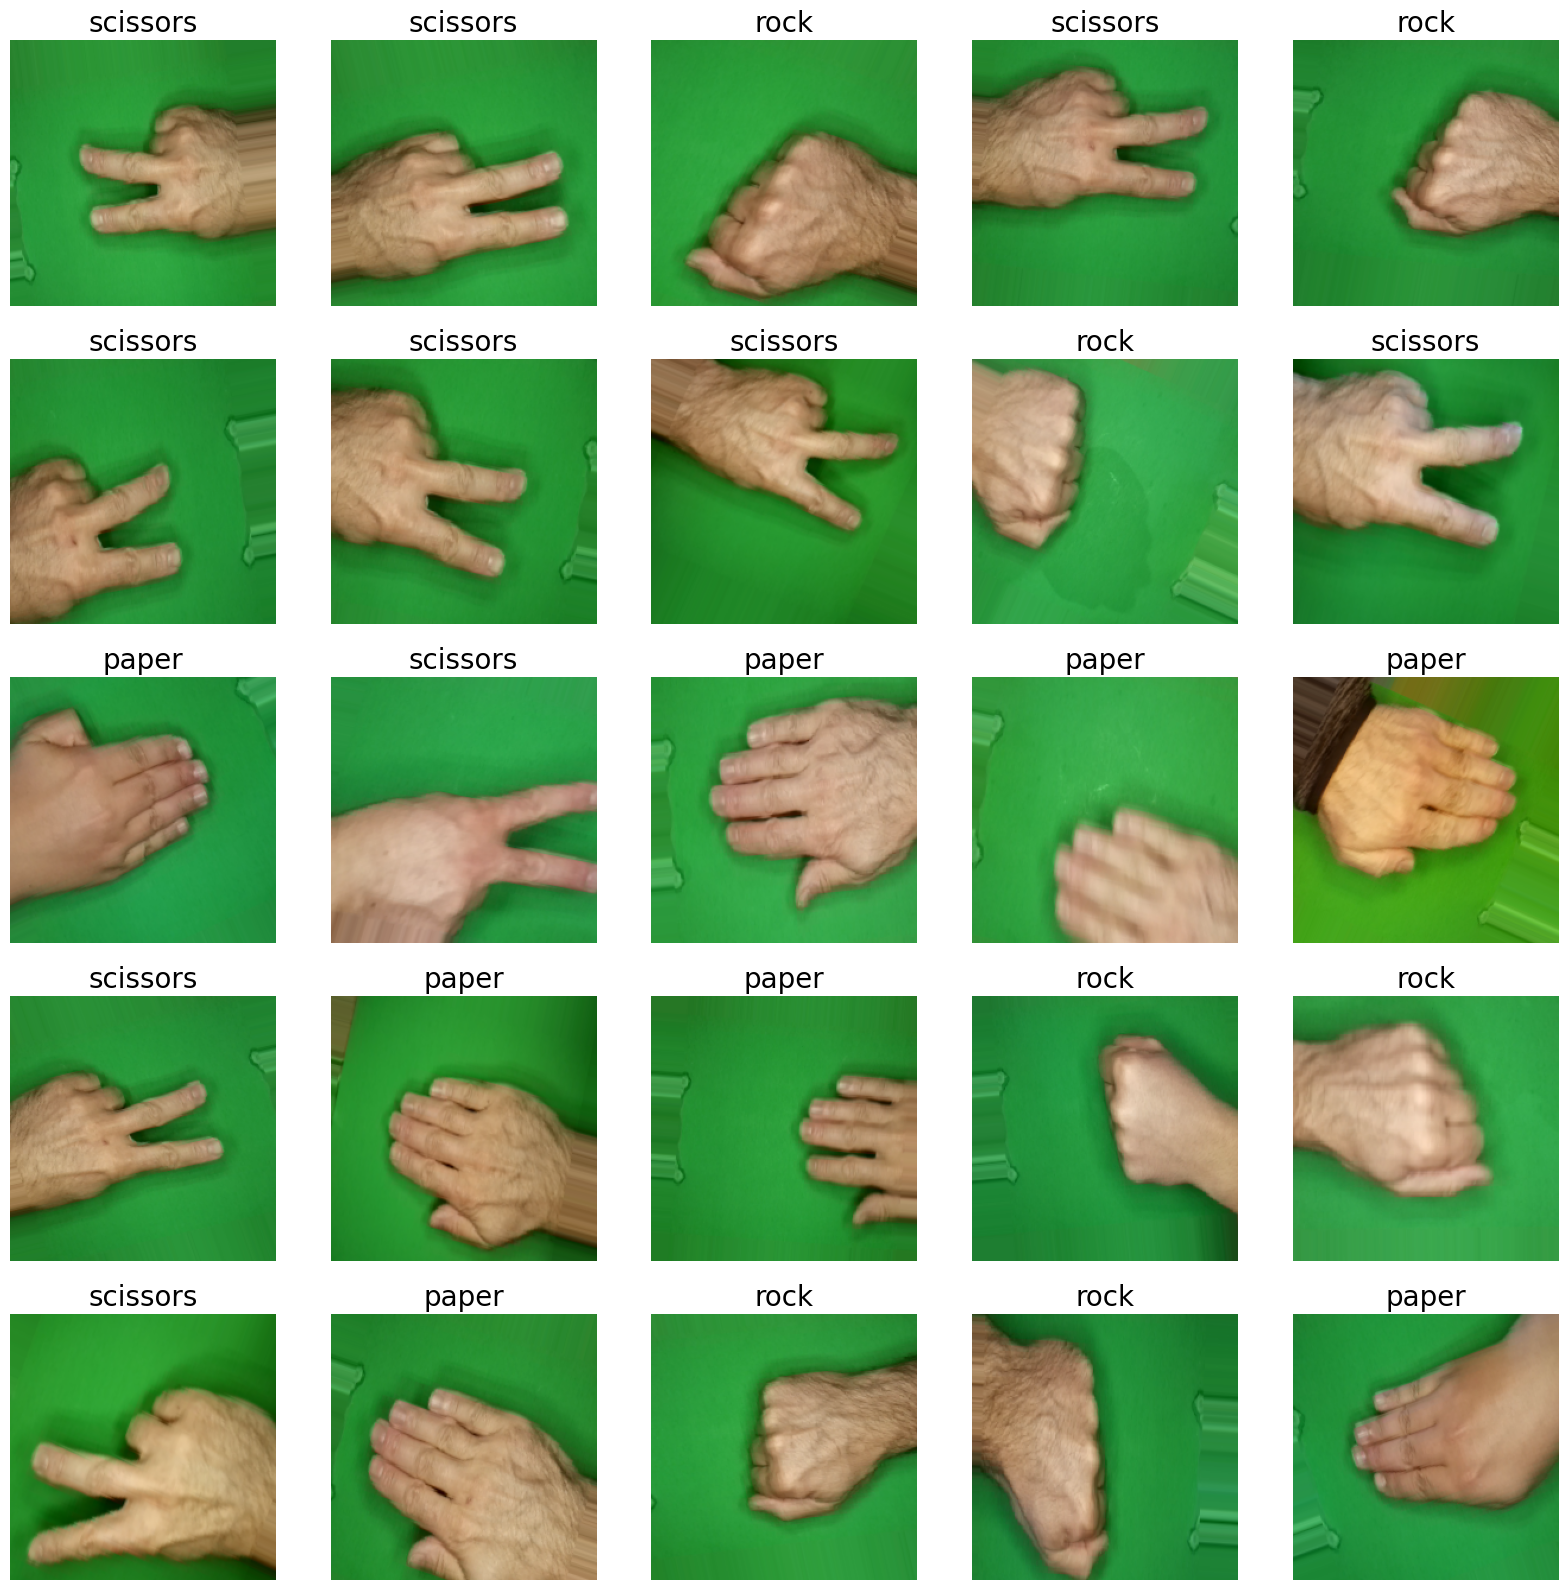

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

show_image_samples(train_gen)

### model CNN

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Activation,Dropout,Conv2D, MaxPooling2D,BatchNormalization, Flatten, Input

base_model=tf.keras.applications.NASNetMobile(include_top=False, weights="imagenet",input_tensor=Input(shape=(224,224,3)))

In [ ]:
base_model.summary()

Model: "NASNet"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 stem_conv1 (Conv2D)         (None, 111, 111, 32)         864       ['input_1[0][0]']             
                                                                                                  
 stem_bn1 (BatchNormalizati  (None, 111, 111, 32)         128       ['stem_conv1[0][0]']          
 on)                                                                                              
                                                                                                  
 activation (Activation)     (None, 111, 111, 32)         0         ['stem_bn1[0][0]']       

In [ ]:
base_model.trainable = False

In [ ]:
model_name='NASNetMobile-Adam_0.0001'
print("Building model with", base_model)
model = tf.keras.Sequential([
            # Note the input shape is the desired size of the image 128x128 with 3 bytes color
            # This is the first convolution
            base_model,
            tf.keras.layers.Conv2D(filters=32, padding='same', kernel_size=3, activation='relu', strides=1),
            tf.keras.layers.MaxPool2D(pool_size=2, strides=2),
            tf.keras.layers.Dropout(rate=0.5),

            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(3, activation='softmax')
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=.0001), loss='categorical_crossentropy', metrics='accuracy')

Building model with <keras.src.engine.functional.Functional object at 0x7b8f02f2e830>


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 NASNet (Functional)         (None, 7, 7, 1056)        4269716   
                                                                 
 conv2d (Conv2D)             (None, 7, 7, 32)          304160    
                                                                 
 max_pooling2d (MaxPooling2  (None, 3, 3, 32)          0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 3, 3, 32)          0         
                                                                 
 flatten (Flatten)           (None, 288)               0         
                                                                 
 dense (Dense)               (None, 3)                 867       
                                                        

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
import time

start_time = time.time()

epochs = 50
mc = ModelCheckpoint('/content/drive/MyDrive/Artificial Intelligence/Klasifikasi batu kertas gunting/NASNetMobile_klasifikasi rockpaperscissors.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', patience=2)
history=model.fit(x=train_gen, epochs=epochs, validation_data=valid_gen, callbacks=[early_stopping, mc])

end_time = time.time()

duration = end_time - start_time
print(f"Durasi waktu: {duration:.2f} detik")

Epoch 1/50
21/21 [==============================] - ETA: 0s - loss: 1.4027 - accuracy: 0.4931
Epoch 1: val_accuracy improved from -inf to 0.84286, saving model to /content/drive/MyDrive/Artificial Intelligence/Klasifikasi batu kertas gunting/NASNetMobile_klasifikasi rockpaperscissors.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


21/21 [==============================] - 74s 2s/step - loss: 1.4027 - accuracy: 0.4931 - val_loss: 0.5699 - val_accuracy: 0.8429
Epoch 2/50
21/21 [==============================] - ETA: 0s - loss: 0.6111 - accuracy: 0.7630
Epoch 2: val_accuracy improved from 0.84286 to 0.91714, saving model to /content/drive/MyDrive/Artificial Intelligence/Klasifikasi batu kertas gunting/NASNetMobile_klasifikasi rockpaperscissors.h5
21/21 [==============================] - 29s 1s/step - loss: 0.6111 - accuracy: 0.7630 - val_loss: 0.2621 - val_accuracy: 0.9171
Epoch 3/50
21/21 [==============================] - ETA: 0s - loss: 0.4172 - accuracy: 0.8407
Epoch 3: val_accuracy improved from 0.91714 to 0.96286, saving model to /content/drive/MyDrive/Artificial Intelligence/Klasifikasi batu kertas gunting/NASNetMobile_klasifikasi rockpaperscissors.h5
21/21 [==============================] - 28s 1s/step - loss: 0.4172 - accuracy: 0.8407 - val_loss: 0.1498 - val_accuracy: 0.9629
Epoch 4/50
21/21 [=============

In [ ]:
train_loss, train_acc = model.evaluate(train_gen)
train_acc_percentage = train_acc * 100
print(f"Akurasi training: {train_acc_percentage:.2f}%")

21/21 [==============================] - 24s 1s/step - loss: 0.0446 - accuracy: 0.9863
Akurasi training: 98.63%


In [ ]:
val_loss, val_acc = model.evaluate(valid_gen)
val_acc_percentage = val_acc * 100
print(f"Akurasi validation: {val_acc_percentage:.2f}%")

6/6 [==============================] - 2s 276ms/step - loss: 0.0286 - accuracy: 0.9857
Akurasi validation: 98.57%


In [ ]:
test_loss, test_acc = model.evaluate(test_gen)
test_acc_percentage = test_acc * 100
print(f"Akurasi testing: {test_acc_percentage:.2f}%")

263/263 [==============================] - 12s 45ms/step - loss: 0.0226 - accuracy: 0.9943
Akurasi testing: 99.43%


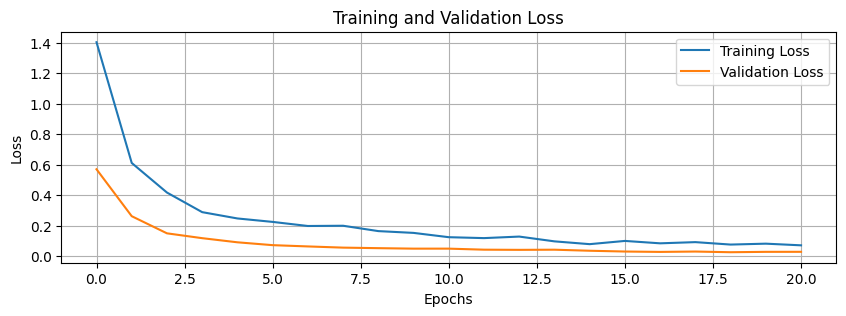

In [ ]:
# Visualisasi grafik training dan validasi loss
plt.figure(figsize=(10, 3))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.grid(True)
plt.show()

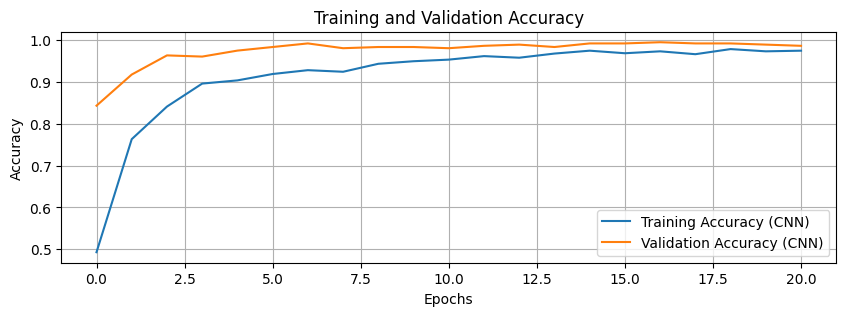

In [ ]:
# Visualisasi grafik training dan validasi accuracy
plt.figure(figsize=(10, 3))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.grid(True)
plt.show()

In [ ]:
class_names = ["Paper", "Rock", "Scissors"]

In [ ]:
from sklearn.metrics import classification_report

# Classification Report dan Confusion Matrix
y_pred = model.predict(test_gen)
y_pred_classes = np.argmax(y_pred, axis=1)
true_labels = test_gen.classes
print("Classification Report:")
print(classification_report(true_labels, y_pred_classes, target_names=class_names))

263/263 [==============================] - 17s 49ms/step
Classification Report:
              precision    recall  f1-score   support

       Paper       1.00      0.99      0.99       178
        Rock       0.99      0.99      0.99       173
    Scissors       0.99      1.00      0.99       175

    accuracy                           0.99       526
   macro avg       0.99      0.99      0.99       526
weighted avg       0.99      0.99      0.99       526



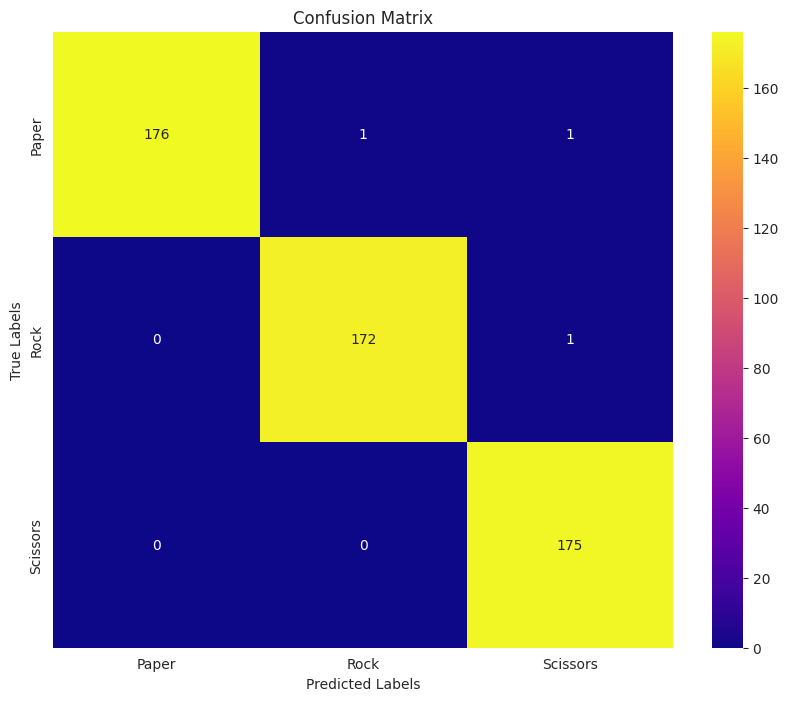

In [ ]:
import seaborn as sns
sns.set_style('whitegrid')

from sklearn.metrics import confusion_matrix

conf_matrix = confusion_matrix(true_labels, y_pred_classes)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="plasma", xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
model.save('/content/drive/MyDrive/Artificial Intelligence/Klasifikasi batu kertas gunting/klasifikasi rockpaperscissors menggunakan NASNetMobile.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
from tensorflow.keras.preprocessing import image
import numpy as np
from IPython.display import Image, display
from PIL import Image as PILImage

def predict_uploaded_image(file_path, model):
    # Membaca dan memproses gambar yang diunggah
    img = image.load_img(file_path, target_size=(224, 224))
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = img / 255.0  # Normalisasi piksel

    # Melakukan prediksi
    prediction = model.predict(img)

    # Mengambil kelas dengan probabilitas tertinggi
    class_index = np.argmax(prediction)

    # Mengecek nama kelas berdasarkan indeks
    if class_index == 0:
        class_name = 'Paper'
    elif class_index == 1:
        class_name = 'Rock'
    else:
        class_name = 'Scissors'

    return class_name, prediction

Saving 0cb6cVL8pkfi4wF6.png to 0cb6cVL8pkfi4wF6 (2).png


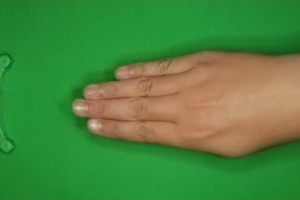

1/1 [==============================] - 5s 5s/step
Gambar "0cb6cVL8pkfi4wF6 (2).png" diprediksi sebagai: Paper
Probabilitas kelas: [[9.9516380e-01 4.0830201e-03 7.5324497e-04]]


In [ ]:
# Gantilah dengan nama model yang sesuai
model = tf.keras.models.load_model('/content/drive/MyDrive/Artificial Intelligence/Klasifikasi batu kertas gunting/klasifikasi rockpaperscissors menggunakan NASNetMobile.h5')

# Unggah gambar menggunakan widget file upload di Colab
from google.colab import files
uploaded = files.upload()

# Ambil nama file gambar yang diunggah
file_names = list(uploaded.keys())

# Menampilkan gambar
for file_name in file_names:
    display(Image(filename=file_name, width=224, height=224))

# Lakukan prediksi untuk setiap gambar yang diunggah
for file_name in file_names:
    class_name, prediction = predict_uploaded_image(file_name, model)
    print(f'Gambar "{file_name}" diprediksi sebagai: {class_name}')
    print(f'Probabilitas kelas: {prediction}')

Saving 0NDYNEoDui7o64gU.png to 0NDYNEoDui7o64gU.png


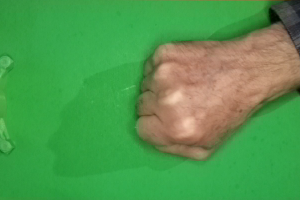

1/1 [==============================] - 0s 350ms/step
Gambar "0NDYNEoDui7o64gU.png" diprediksi sebagai: Rock
Probabilitas kelas: [[6.4662971e-05 9.9987543e-01 5.9899077e-05]]


In [ ]:
# Unggah gambar menggunakan widget file upload di Colab
from google.colab import files
uploaded = files.upload()

# Ambil nama file gambar yang diunggah
file_names = list(uploaded.keys())

# Menampilkan gambar
for file_name in file_names:
    display(Image(filename=file_name, width=224, height=224))

# Lakukan prediksi untuk setiap gambar yang diunggah
for file_name in file_names:
    class_name, prediction = predict_uploaded_image(file_name, model)
    print(f'Gambar "{file_name}" diprediksi sebagai: {class_name}')
    print(f'Probabilitas kelas: {prediction}')

Saving 2DEYFsJ27UgVqv3W.png to 2DEYFsJ27UgVqv3W (2).png


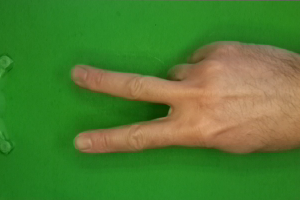

1/1 [==============================] - 0s 62ms/step
Gambar "2DEYFsJ27UgVqv3W (2).png" diprediksi sebagai: Scissors
Probabilitas kelas: [[1.7831383e-07 7.5623126e-09 9.9999976e-01]]


In [ ]:
# Unggah gambar menggunakan widget file upload di Colab
from google.colab import files
uploaded = files.upload()

# Ambil nama file gambar yang diunggah
file_names = list(uploaded.keys())

# Menampilkan gambar
for file_name in file_names:
    display(Image(filename=file_name, width=224, height=224))

# Lakukan prediksi untuk setiap gambar yang diunggah
for file_name in file_names:
    class_name, prediction = predict_uploaded_image(file_name, model)
    print(f'Gambar "{file_name}" diprediksi sebagai: {class_name}')
    print(f'Probabilitas kelas: {prediction}')